# Bench WS Analysis
### Anish Shourie

Trying to determine which teams' benches contribute the most.

#### Analysis 1: 
Calculating which teams use utilize their benches the most (and which of those benches contribute the most) in comparsion to the starters using total win shares (WS)
#### Analysis 2: 
Analyzing which teams' benches contribute the most WS based on the number of minutes they play (using WS/48)
#### How to determine a team's "bench" since each game could potentially have a different lineup
I'm filtering out...
1. The top 5 players on a team in terms of percentage of games started (GS/GP)
2. Players who started more than 70% of the games they played in
3. Players who played at least 85% of the team's games for the season and started in more than 50% of those games
4. Players who played at least 50% of the team's games for the season and started in more than 60% of those games
5. Rest of the team is defined as the bench players

*These filters account for if a player has been traded mid-season or players had to sit out with injuries

*More than means >

In [243]:
from urllib.request import urlopen
from bs4 import BeautifulSoup, Comment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

year = 2013
season = str(year-1) + "-" + str(year)

# Configure this dictionary with the list of teams that played in the particular season
tms = {
    "ATL" : "Atlanta Hawks",
    "BOS" : "Boston Celtics",
    "BRK" : "Brooklyn Nets",
    "CHA" : "Charlotte Bobcats",
    "CHH" : "Charlotte Hornets",
    "CHO" : "Charlotte Hornets",
    "CHI" : "Chicago Bulls",
    "CLE" : "Cleveland Cavaliers",
    "DAL" : "Dallas Mavericks",
    "DEN" : "Denver Nuggets",
    "DET" : "Detroit Pistons",
    "GSW" : "Golden State Warriors",
    "HOU" : "Houston Rockets",
    "IND" : "Indiana Pacers",
    "KCK" : "Kansas City Kings",
    "LAC" : "Los Angeles Clippers",
    "LAL" : "Los Angeles Lakers",
    "MEM" : "Memphis Grizzlies",
    "MIA" : "Miami Heat",
    "MIL" : "Milwaukee Bucks",
    "NJN" : "New Jersey Nets",
    "NOH" : "New Orleans Hornets",
    "NOK" : "New Orleans/Oklahoma City Hornets",
    "NOP" : "New Orleans Pelicans",
    "NYK" : "New York Knicks",
    "MIN" : "Minnesota Timberwolves",
    "SEA" : "Seattle SuperSonics",
    "OKC" : "Oklahoma City Thunder",
    "ORL" : "Orlando Magic",
    "PHI" : "Philadelphia 76ers",
    "PHO" : "Phoenix Suns",
    "POR" : "Portland Trail Blazers",
    "SAC" : "Sacramento Kings",
    "SAS" : "San Antonio Spurs",
    "TOR" : "Toronto Raptors",
    "UTA" : "Utah Jazz",
    "VAN" : "Vancouver Grizzlies",
    "WAS" : "Washington Wizards",
    "WSB" : "Washington Bullets"
    
}

In [244]:
# Getting the team records for each team for a given season

url = "https://www.basketball-reference.com/leagues/NBA_{}_standings.html".format(year)
html = urlopen(url)
soup = BeautifulSoup(html, "lxml")

comments = soup.find_all(string=lambda text:isinstance(text,Comment))

def get_table(comments,s):
    for comment in comments:
        comment1 = BeautifulSoup(str(comment), 'lxml')
        table = comment1.find(id = s) # edit this line to get a different table
        if table:
            break
    return table

def scrape(tbl):
    headers = [th.getText() for th in tbl.find_all('tr')[1].findAll('th')]
    headers = headers[1:]
    rows = tbl.find_all('tr')[2:]
    records = [[td.getText() for td in rows[i].findAll('td')]
            for i in range(len(rows))]
    df = pd.DataFrame(records, columns = headers)
    return df

standings = scrape(get_table(comments, 'div_expanded_standings'))
standings = standings.set_index('Team')

def get_num(s,wl):
    s = s.split("-")
    if wl == 'wins':
        return int(s[0])
    else:
        return int(s[1])
    
tm_records = pd.DataFrame(index = standings.index, columns = ['wins','losses','pct','ws','min','bench_min',\
                                                              'bench_ws', 'E[bench_ws]', 'bench_ws/48', \
                                                              'E[bench_ws/48]', 'resid_ws', 'resid_ws/48'])
for index, row in tm_records.iterrows():
    s = standings.loc[index,'Overall']
    tm_records.loc[index,'wins'] = get_num(s,'wins')
    tm_records.loc[index,'losses'] = get_num(s,'losses')
tm_records['pct'] = tm_records['wins']/(tm_records['wins'] + tm_records['losses'])
tm_records = tm_records.sort_values('pct', ascending = False)

In [245]:
# Getting and cleaning the advanced stats for all players in a certain season

url = "https://www.basketball-reference.com/leagues/NBA_{}_advanced.html".format(year)
html = urlopen(url)
soup = BeautifulSoup(html, "lxml")

table = soup.find(id = "advanced_stats")
headers = [th.getText() for th in table.find_all('tr')[0].findAll('th')]
headers = headers[1:]
rows = table.find_all('tr')[1:]
stats = [[td.getText() for td in rows[i].findAll('td')]
        for i in range(len(rows))]
advanced = pd.DataFrame(stats, columns = headers)

for index, row in advanced.iterrows():
    if row['Tm'] == 'TOT' or row['Tm'] == None:
        advanced = advanced.drop(index)
    else:
        advanced.loc[index, 'WS'] = float(advanced.loc[index, 'WS'])
        advanced.loc[index, 'MP'] = float(advanced.loc[index, 'MP'])
        
# Getting and cleaning the total stats for all players in a certain season

url = "https://www.basketball-reference.com/leagues/NBA_{}_totals.html".format(year)
html = urlopen(url)
soup = BeautifulSoup(html, "lxml")

table = soup.find(id = "totals_stats")
headers = [th.getText() for th in table.find_all('tr')[0].findAll('th')]
headers = headers[1:]
rows = table.find_all('tr')[1:]
stats = [[td.getText() for td in rows[i].findAll('td')]
        for i in range(len(rows))]
totals = pd.DataFrame(stats, columns = headers)

for index, row in totals.iterrows():
    if row['Tm'] == 'TOT' or row['Tm'] == None:
        totals = totals.drop(index)
    else:
        totals.loc[index, 'G'] = float(totals.loc[index, 'G'])
        totals.loc[index, 'GS'] = float(totals.loc[index, 'GS'])


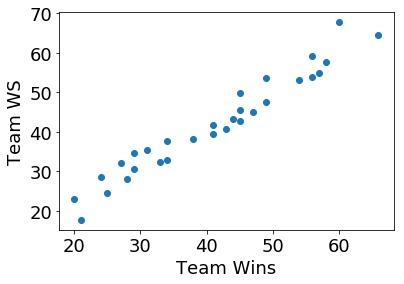

In [246]:
# Filtering each team for its bench players

all_stats = totals.merge(advanced, on=['Player','Tm'])
       
def get_bench(df):
    tmp = pd.DataFrame()
    for tm in tms.keys():
        try:
            tm_gp = tm_records.loc[tms[tm], 'wins'] + tm_records.loc[tms[tm], 'losses']
        except:
            continue
        tmp = df[df['Tm'] == tm].copy()
        tm_records.loc[tms[tm],'ws'] = tmp['WS'].sum()
        tm_records.loc[tms[tm],'min'] = tmp['MP_y'].sum()
        tmp['pct_GP'] = tmp['GS']/tmp['G_x']
        tmp = tmp.sort_values('pct_GP', ascending=False)
        tmp = tmp[5:]
        for index, row in tmp.iterrows():
            if row['pct_GP'] > 0.70:
                tmp = tmp.drop(index)
            elif row['G_x']/tm_gp >= 0.85 and row['pct_GP'] > 0.5:
                tmp = tmp.drop(index)
            elif row['G_x']/tm_gp >= 0.5 and row['pct_GP'] > 0.6:
                tmp = tmp.drop(index)
        tm_records.loc[tms[tm],'bench_ws'] = tmp['WS'].sum()
        tm_records.loc[tms[tm],'bench_min'] = tmp['MP_y'].sum()
        
get_bench(all_stats)
plt.xlabel('Team Wins')
plt.ylabel('Team WS')
plt.scatter(tm_records['wins'], tm_records['ws'])
plt.show()

In [247]:
tm_records['bench_ws/48'] = 48 *(tm_records['bench_ws']/tm_records['bench_min'])
x1 = tm_records['wins'].values.reshape(-1, 1)
y1 = tm_records['bench_ws'].values.reshape(-1, 1)
y2 = tm_records['bench_ws/48'].values.reshape(-1, 1)

model1 = LinearRegression()
model1.fit(x1, y1)
y_pred1 = model1.predict(x1)

model2 = LinearRegression()
model2.fit(x1, y2)
y_pred2 = model2.predict(x1)

tm_records['E[bench_ws]'] = y_pred1
tm_records['resid_ws'] = tm_records['bench_ws'] - tm_records['E[bench_ws]']

tm_records['E[bench_ws/48]'] = y_pred2
tm_records['resid_ws/48'] = tm_records['bench_ws/48'] - tm_records['E[bench_ws/48]']

tm_records = tm_records.sort_values('resid_ws', ascending=False)
display(tm_records)

,wins,losses,pct,ws,min,bench_min,bench_ws,E[bench_ws],bench_ws/48,E[bench_ws/48],resid_ws,resid_ws/48
Team,,,,,,,,,,,,
Boston Celtics,41,40,0.506173,41.6,19843,10149,20.5,14.453325,0.0969554,0.081397,6.04667,0.0155586
Philadelphia 76ers,34,48,0.414634,32.8,19755,10103,18.2,12.355038,0.0864694,0.068155,5.84496,0.0183141
Toronto Raptors,34,48,0.414634,37.6,19979,9656,17.3,12.355038,0.0859983,0.068155,4.94496,0.0178431
Chicago Bulls,45,37,0.54878,42.8,19831,9104,20,15.652346,0.105448,0.088963,4.34765,0.0164848
Detroit Pistons,29,53,0.353659,30.5,19806,8328,14.7,10.856262,0.0847262,0.058697,3.84374,0.0260292
New York Knicks,54,28,0.658537,53.1,19731,8985,21.9,18.350143,0.116995,0.105988,3.54986,0.0110068
Dallas Mavericks,41,41,0.5,39.5,19980,9432,17.7,14.453325,0.0900763,0.081397,3.24667,0.00867954
Utah Jazz,43,39,0.52439,40.8,19881,9534,17.7,15.052836,0.0891126,0.085180,2.64716,0.00393256
Los Angeles Clippers,56,26,0.682927,59.1,19730,9302,21,18.949654,0.108364,0.109772,2.05035,-0.00140774


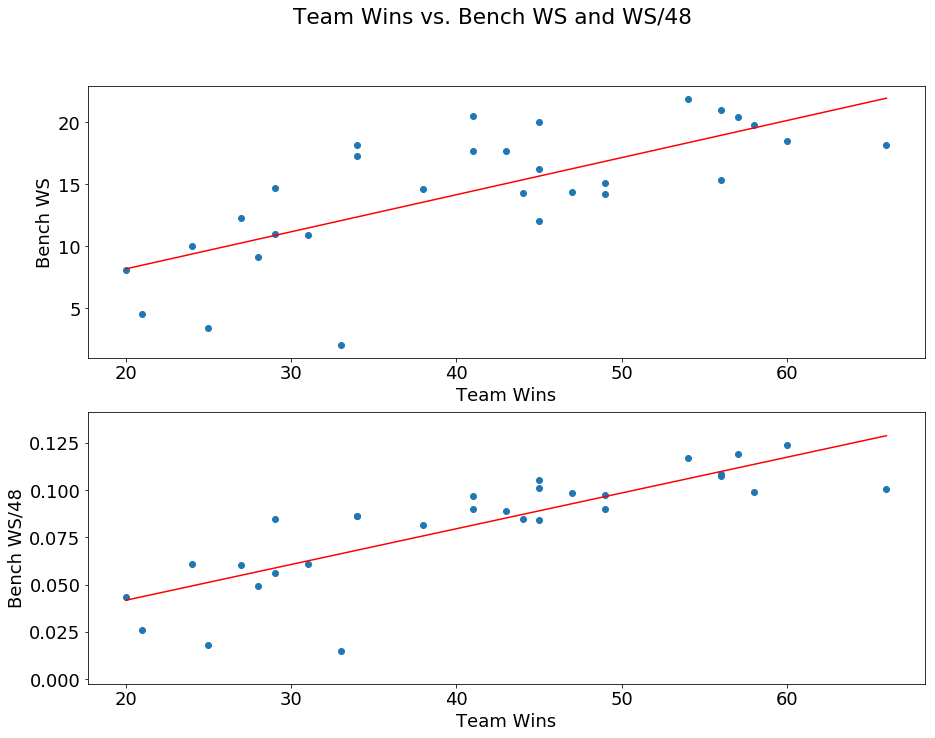

In [248]:
plt.rcParams.update({'font.size': 18})
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 11))
fig.suptitle('Team Wins vs. Bench WS and WS/48')

ax1.scatter(x1, y1)
ax1.plot(x1, y_pred1, color='red')
ax1.set(xlabel = 'Team Wins', ylabel = "Bench WS")

ax2.set(xlabel = 'Team Wins', ylabel = "Bench WS/48")
ax2.scatter(x1, y2)
ax2.plot(x1, y_pred2, color='red')

plt.show()